In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import subprocess
import datetime
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox

import warnings
warnings.filterwarnings('ignore')

In [2]:
home_dir = '/home/jupyter/data_science_projects/business_data_science'

data_dir = os.path.join(home_dir, 'data/external/OnlineRetail.csv')

cluster_no = 4

In [3]:
df = pd.read_csv(data_dir, encoding="unicode_escape").drop_duplicates().dropna().reset_index(drop=True)

# Changing data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# time series variables
df['date'] = pd.to_datetime(df.InvoiceDate).dt.date
df['year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['yearmo'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%Y%m')
# new variable

df['Revenue'] = df['Quantity'] * df['UnitPrice']

### Convenience Functions

In [4]:
def transform_and_scale(data, reverse_field=None):
    """
    Purpose: Transform data using Boxcox and StandardScaler
    Input: data - a dataframe column
    Output: transformed data
    """
    print('Transforming using Boxcox and StandardScaler...')
    if reverse_field:
        print(f'With Reverse Field(s): {reverse_field}')
    #print(data.head())
    if not isinstance(data,pd.core.frame.DataFrame):
        data = data.to_frame()
    for c in data.columns:
        print(f"Transforming {c}...")
        v,l = boxcox(abs(data[c]+.0000000001))
        data[c] = v
        
        print(f"Scaling {c}...")
        scaler = MinMaxScaler()
        data[c] = scaler.fit_transform(np.array(data[c].to_frame()))
        
        if reverse_field:
            print(f"Reversing {c}...")
            data[c] = 1 - data[c] 
           
    #print(data.head())
    return data

def plot_cluster_graph(data, transform_and_scale_data=True):
    
    """
    Purpose: Plot cluster graph
    Input: 
        data - a dataframe column
        transform_and_scale - boolean.  Default is True.  If False, data is not transformed via boxcox transform or scaled via StandardScaler
    Output: A scree plot that allows us to determine optimal number of clusters
    """

    
    print('Plotting cluster graph...')
    
    #Sum of Sqared Errors
    sse = {}

    if transform_and_scale_data:
        #Scales and Transforms data
        data = transform_and_scale(data)

    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(data)
        sse[k] = kmeans.inertia_

    plt.figure(figsize=(10, 5))
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    
def plot_cluster_scatter(data, cols, label, n, transform_and_scale_data=True, algorithm='PCA'): 
    
    plt.figure(figsize=(10, 5))
    
    if transform_and_scale_data:
        #Scales and Transforms data
        data[cols] = transform_and_scale(data[cols])
    
    if algorithm.lower() == 'pca':
    
        from sklearn.decomposition import PCA
    
        pca = PCA()
    
        results = pd.DataFrame(pca.fit_transform(data[cols]))

        results.columns = [f'PC{i+1}' for i in range(results.shape[1])]

        data['PC1'] = results['PC1']

        data['PC2'] = results['PC2']
        
        sns.scatterplot(x='PC1',y='PC2', hue=label, palette=sns.color_palette("hls",10),data=data)
        
    if re.sub('-', '', algorithm.lower()) == 'tsne':
        
        from sklearn.manifold import TSNE
        
        tSNE=TSNE()
        
        results=tSNE.fit_transform(data)
        
        data['X'] = results[:,0]

        data['Y'] = results[:,1]
    
        sns.scatterplot(x='X',y='Y', hue=label, palette=sns.color_palette("hls",10),data=data)
        
    if algorithm.lower() == 'lda':
        
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        
        lda = LinearDiscriminantAnalysis()
        
        results = lda.fit_transform(data[cols], data[label])
        
        data['LD1'] = results[:,0]

        data['LD2'] = results[:,1]
        
        sns.scatterplot(x='LD1',y='LD2', hue=label, palette=sns.color_palette("hls",10),data=data)

def assign_cluster(data, n_clusters, reverse_field=None):
    """
    Purpose: Assign cluster
    Input: 
        data - a dataframe column
        n_clusters - number of clusters
        reverse_field - list or string for columns to reverse
    Output:
        an array with a new column called Cluster
        """
    
    #Scales and Transforms data
    data = transform_and_scale(data, reverse_field=reverse_field)
    
    print('Assigning cluster...')
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000, n_init='auto')
    
    # Predicts Cluster
    data['clusters'] = kmeans.fit_predict(data) + 1
    
    return data['clusters']

def rerank_clusters(data, data_col, cluster_col, reverse_field=None):
    """
    Purpose: Rerank clusters
    Input:
        data - a dataframe 
        data_col - a column name for the column representing the data
        cluster_col - a column name for the column representing a cluster to rerank
            
    Output:
        data - a dataframe 
    
    """
    
    if isinstance(data_col, list):
        data['new_data_col'] = np.sum(data[data_col], axis=1)
        data_col = 'new_data_col'
          
    tdf = data.groupby(cluster_col, as_index=False)\
    .agg(NewCluster = (data_col, 'mean'))\
    .rank(method="dense")
    
    if reverse_field:
        print(f'Reversing {reverse_field} clusters...')
        tdf.sort_values('NewCluster', ascending=False, inplace=True)
        l = tdf['NewCluster'].to_list()
        l.reverse()
        tdf['NewCluster'] = l
    
    data = data.merge(tdf
      , on=cluster_col, how='inner')\
      .rename(columns={cluster_col:"drop_column"})\
      .rename(columns={'NewCluster':cluster_col})\
      .drop('drop_column', axis=1)\

    if isinstance(data_col, list):
        data.drop(columns='new_data_col', axis=1, inplace=True)
        
    return data

def generate_cluster_df(df, n_clusters,col=None, reverse_field=None):
    """
    Purpose: Generate cluster data
    Input: 
        df - a dataframe column
        n_clusters - number of clusters
        col - a column name
        reverse_field - list or string for columns to reverse
    Output: 
        a dataframe with a new column called Cluster
        """
    #print(df.head())
    #print(reverse_field)
    if isinstance(col, str):
        output_col_name = f'{col}Cluster'
        
    elif isinstance(col, list):
        output_col_name = 'FinalCluster'
    
    df[output_col_name] = assign_cluster(df[col], n_clusters,reverse_field=reverse_field)
    
    df = rerank_clusters(df, cluster_col = output_col_name, data_col=col, reverse_field=reverse_field)
    #print(df.head())
    return df

def analyze_clusters(df,col, n_clusters:int, reverse_field=None):
    """
    Purpose: Analyze clusters
    Input: 
        df - a dataframe column
        col - a column name
        n_clusters - number of clusters
        reverse_field - column name or list of column names. If reverse_field is not None, reverses the fieldeven without "reverse" being true.
        
    Output: 
        a dataframe with a new column called Cluster
        """
    if reverse_field and not isinstance(reverse_field, list):
        reverse_field = [reverse_field]

    df =  generate_cluster_df(df=df, n_clusters=n_clusters, col=col, reverse_field=reverse_field)
    
    return df


### RECENCY, FREQUENCY, MONETARY ANALYSIS 
Objective is to find the RFM for each customer to determing Low, Medium and High Value Customers

In [5]:
# We drop returns.
new_df = df.loc[~df.InvoiceNo.str.contains('C')].copy()

#### Recency

In [6]:
new_df['Recency'] =  (pd.to_datetime(new_df.InvoiceDate).max() - new_df.InvoiceDate).dt.days

Plotting cluster graph...
Transforming using Boxcox and StandardScaler...
Transforming Recency...
Scaling Recency...


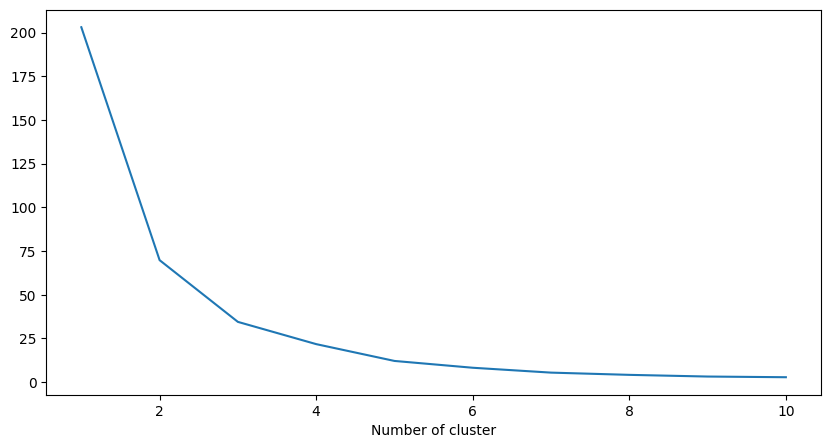

In [7]:
r_df = new_df.groupby(['CustomerID']).agg({'InvoiceDate': 'max'}).reset_index()\
.merge(new_df[['CustomerID', 'InvoiceDate','Recency']], on=['CustomerID','InvoiceDate'], how='inner')\
.drop_duplicates().reset_index(drop=True).drop(['InvoiceDate'], axis=1)

#r_df.Recency.describe()
plot_cluster_graph(r_df['Recency'])

Scree plot shows 3 or 4 clusters would be optimal

In [8]:
r_df = analyze_clusters(r_df, n_clusters=cluster_no,col ='Recency',reverse_field='Recency')
r_df.groupby('RecencyCluster')['Recency'].describe()

Transforming using Boxcox and StandardScaler...
With Reverse Field(s): ['Recency']
Transforming Recency...
Scaling Recency...
Reversing Recency...
Assigning cluster...
Reversing ['Recency'] clusters...


count        mean        std    min     25%    50%    75%  \
RecencyCluster                                                               
1.0             1124.0  242.113879  68.717947  134.0  183.00  238.0  296.0   
2.0             1324.0   72.783988  25.717228   38.0   51.75   67.0   89.0   
3.0             1427.0   19.367204   8.868827    6.0   11.00   18.0   27.0   
4.0              464.0    2.066810   1.482022    0.0    1.00    2.0    3.0   

                  max  
RecencyCluster         
1.0             373.0  
2.0             133.0  
3.0              37.0  
4.0               5.0

#### Frequency
We are going to use the formula:
Frequency = 1 / Median( Time between Purchases)

In [9]:
f_df = new_df[['InvoiceDate','CustomerID']].drop_duplicates().sort_values(by=['CustomerID','InvoiceDate'], ascending=True).reset_index(drop=True)

#Creating difference between invoice dates per person
f_df['Offset'] = f_df.groupby(['CustomerID'])['InvoiceDate'].diff().dt.seconds

# Creating Count per user
f_df = f_df.merge(\
    f_df.groupby(['CustomerID']).agg(Count = ('InvoiceDate', 'count')).reset_index()\
           ,on=['CustomerID'], how='inner')

# Finding folks who only had one interaction and giving them an Offset that is differenced from the latest day in the dataset
f_df.loc[f_df.Count == 1, 'Offset'] = (f_df.InvoiceDate.max() - f_df.InvoiceDate).dt.seconds

# Dropping the first occurance of a invoicedate.  Not needed to make agg.
f_df = f_df.loc[~(f_df.Offset.isna())]

f_df = f_df.groupby(['CustomerID']).agg(Frequency = ('Offset','median')).reset_index()

#f_df['FrequencyHertz'] = 1/f_df.Frequency

Plotting cluster graph...
Transforming using Boxcox and StandardScaler...
Transforming Frequency...
Scaling Frequency...


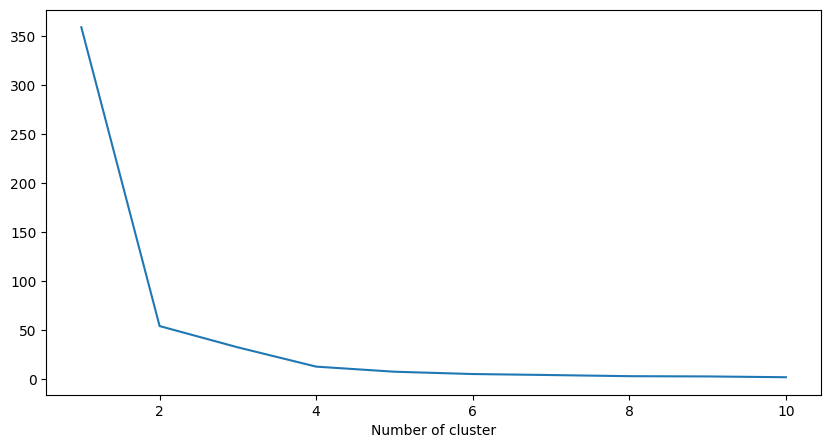

In [10]:
plot_cluster_graph(f_df['Frequency'])

Take

In [11]:
f_df = analyze_clusters(f_df, 'Frequency', cluster_no, reverse_field='Frequency')
f_df.groupby('FrequencyCluster')['Frequency'].describe()

Transforming using Boxcox and StandardScaler...
With Reverse Field(s): ['Frequency']
Transforming Frequency...
Scaling Frequency...
Reversing Frequency...
Assigning cluster...
Reversing ['Frequency'] clusters...


count          mean          std      min      25%  \
FrequencyCluster                                                        
1.0               1766.0  77443.522084  5984.954758  58740.0  73515.0   
2.0                663.0  41319.185520  6641.190148  22860.0  39510.0   
3.0               1221.0  11315.380835  4292.519986   5220.0   7800.0   
4.0                689.0   2335.297533  1564.754496      0.0    900.0   

                      50%      75%      max  
FrequencyCluster                             
1.0               78420.0  82320.0  86340.0  
2.0               42390.0  45090.0  57300.0  
3.0               10560.0  13950.0  22830.0  
4.0                2340.0   3690.0   5160.0

#### Monetary

In [12]:
# We use DF instead of new_df here because we want to penalize users for their returns.
m_df = df[['CustomerID','Revenue']].groupby('CustomerID').agg(Revenue = ('Revenue', 'sum')).reset_index()

Plotting cluster graph...
Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...


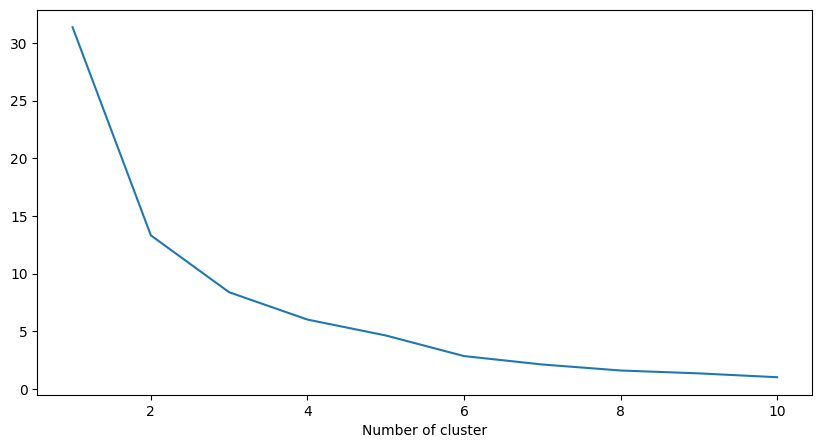

In [13]:
plot_cluster_graph(m_df['Revenue'])

Takeaways:  There seems to be somewhere between 3 and 4 clusters

In [14]:
m_df = analyze_clusters(m_df, 'Revenue', cluster_no)
m_df.groupby('RevenueCluster')#['Revenue'].describe()

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Assigning cluster...


In [15]:
final_df = m_df.merge(r_df, on='CustomerID', how='inner').merge(f_df, on='CustomerID', how='inner')

final_df = final_df[['CustomerID','Recency','Frequency','Revenue','RecencyCluster','FrequencyCluster','RevenueCluster']]

Plotting cluster graph...
Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


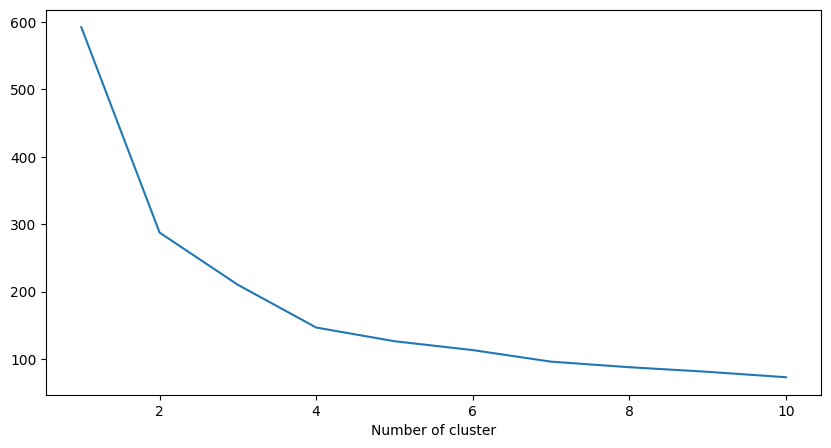

In [16]:
plot_cluster_graph(final_df[['Revenue', 'Frequency', 'Recency']])

Takeaways: We have four clusters.

In [17]:
rfm = analyze_clusters(final_df, ['Revenue', 'Frequency', 'Recency'], cluster_no, reverse_field=['Recency', 'Frequency'])
#rfm2=analyze_clusters(final_df, ['Revenue', 'Frequency', 'Recency'], 4)

Transforming using Boxcox and StandardScaler...
With Reverse Field(s): ['Recency', 'Frequency']
Transforming Revenue...
Scaling Revenue...
Reversing Revenue...
Transforming Frequency...
Scaling Frequency...
Reversing Frequency...
Transforming Recency...
Scaling Recency...
Reversing Recency...
Assigning cluster...
Reversing ['Recency', 'Frequency'] clusters...


In [18]:
rfm.head()

CustomerID  Recency  Frequency  Revenue  RecencyCluster  FrequencyCluster  \
0     12346.0      325    10140.0     0.00             1.0               3.0   
1     12441.0      366     7500.0   173.55             1.0               3.0   
2     12450.0      155      300.0   197.88             1.0               4.0   
3     12492.0       62     1440.0   263.21             2.0               4.0   
4     12506.0      232    14160.0    73.50             1.0               3.0   

   RevenueCluster  new_data_col  FinalCluster  
0             1.0      10465.00           4.0  
1             1.0       8039.55           4.0  
2             1.0        652.88           4.0  
3             1.0       1765.21           4.0  
4             1.0      14465.50           4.0

### INITIAL DATA COMPARISON

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


<Axes: >

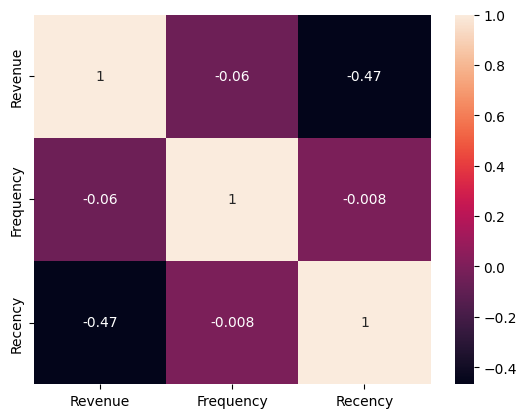

In [20]:
sns.heatmap(transform_and_scale(rfm[['Revenue', 'Frequency', 'Recency']]).corr() ,annot=True)

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


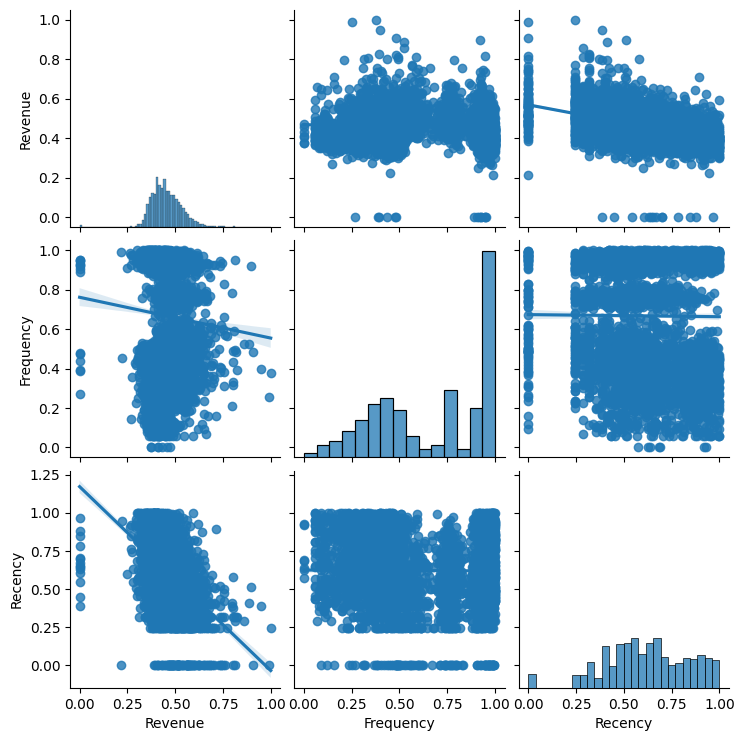

In [21]:
sns.pairplot(transform_and_scale(rfm[['Revenue', 'Frequency', 'Recency']]), palette=sns.color_palette("hls",10), kind='reg')

Takeaways:  There's either not much of a linear relationship between the variables OR the linear relationship is very weak.

Revenue:
* Revenue and Frequency seem to have a linear relationship of no consequence (regression line is flat).
* Revenue and Recency also seems to have linear relationship, but the relationship is negative and there is a "unexplained gap"

Frequency:
* Frequency and Revenue appear to have a linearm and the relationship is negative, this is not the case.  The clustering of the scatter shows that the linear regression used to find the relationship "missed the mark." There is no relationship between Frequency and Recency.
* Frequency and Recency also appear to have a linear relationship, but as is the case with Frequency and Recency, the regression is spurious.

Recency:
* Recency and Revenue seem to have a linear relationship.  The relationship is negative and there is a "unexplained gap."  Also, the clustering seems to show that the strength of the relationship is weak.
* Recency and Frequency seems to have no linear relationship and there is a "unexplained gap."  The clustering is also suspect.

## Plotting Clusters

### Final Clusters

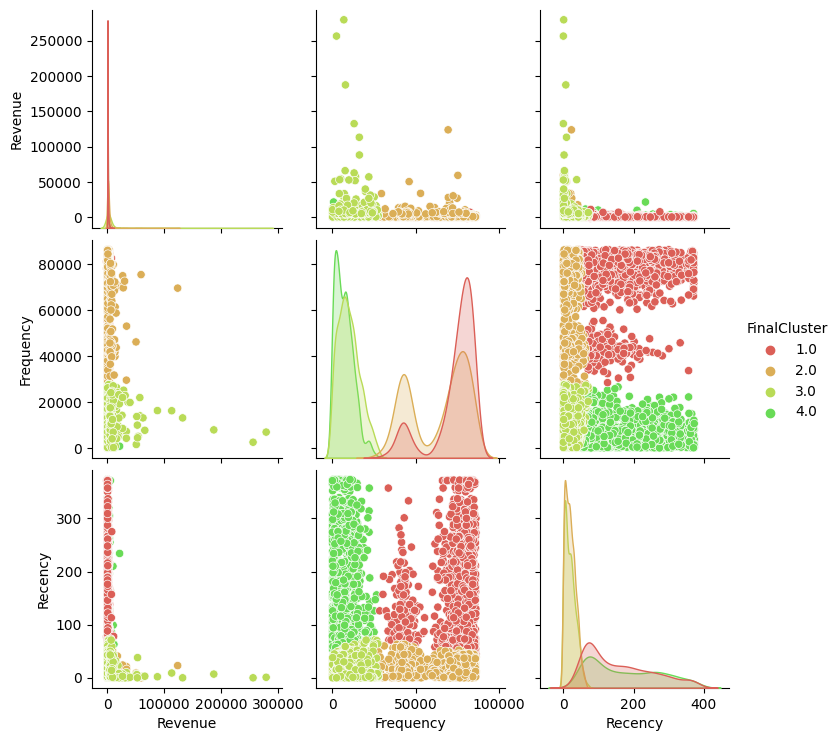

In [22]:
sns.pairplot(rfm[['Revenue', 'Frequency', 'Recency', 'FinalCluster']], hue='FinalCluster', palette=sns.color_palette("hls",10))

Takeaways: 

* The Final Cluster seems to a mixed relationship to our variables and doesn't really line up with the structure of the bivatiate relationships between our variables.
* The overlap between cluster distributions is substantial.
* However, the division between the lower value (1 and 2) clusters and the (3 and 4) clusters is very clear, but doesn't intuitively line up with bivariate relationships.


#### PCA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


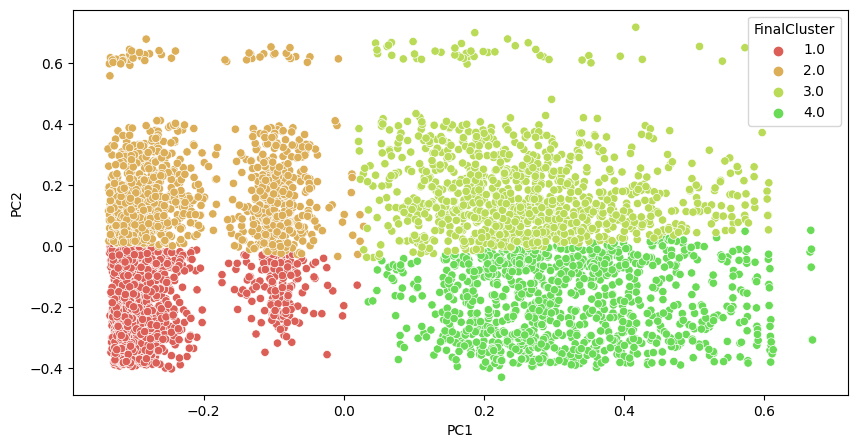

In [23]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='FinalCluster', n=cluster_no, transform_and_scale_data=True, algorithm='pca')

Takeaways:

* PCA seems to rotate the relationships between split the populations into three four clusters, one of which is a thin strata.  Admittedly, one of these might be due to some sort of truncation in the data.

#### TSNE

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


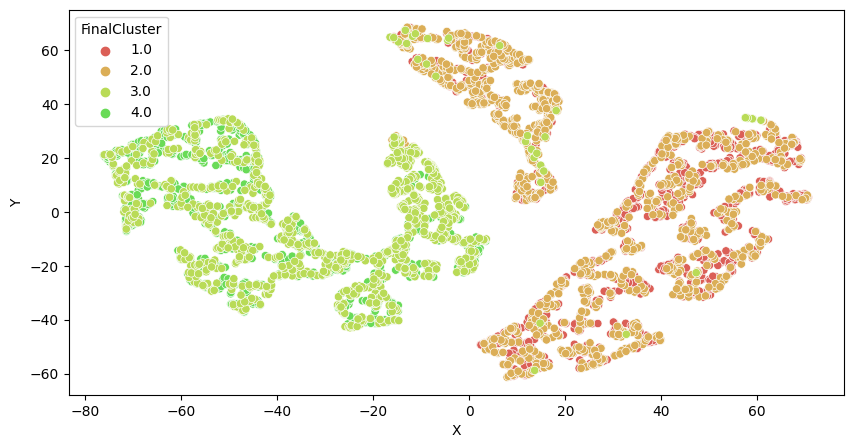

In [24]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='FinalCluster', n=cluster_no, transform_and_scale_data=True, algorithm='tsne')

#### LDA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


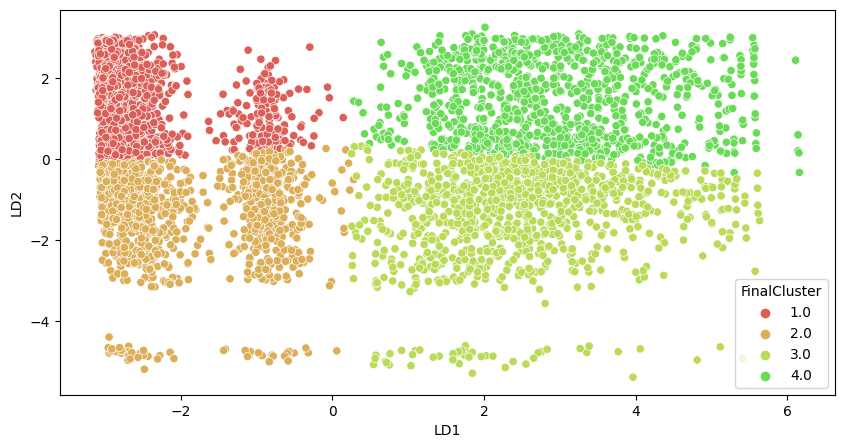

In [25]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='FinalCluster', n=cluster_no, transform_and_scale_data=True, algorithm='LDA')

### Recency

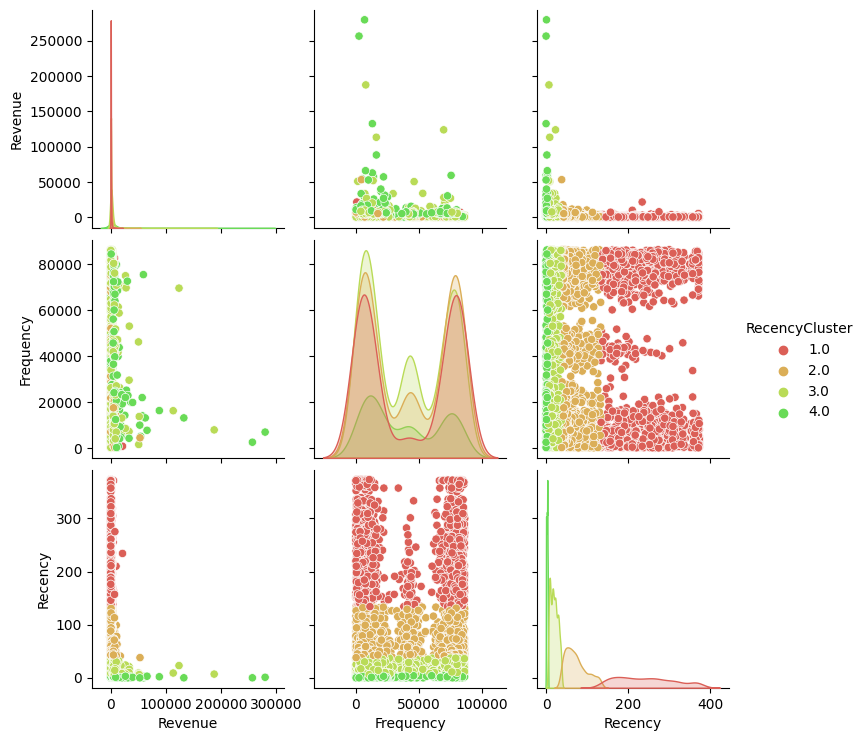

In [26]:
sns.pairplot(rfm[['Revenue', 'Frequency', 'Recency', 'RecencyCluster']], hue='RecencyCluster', palette=sns.color_palette("hls",10))

#### PCA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


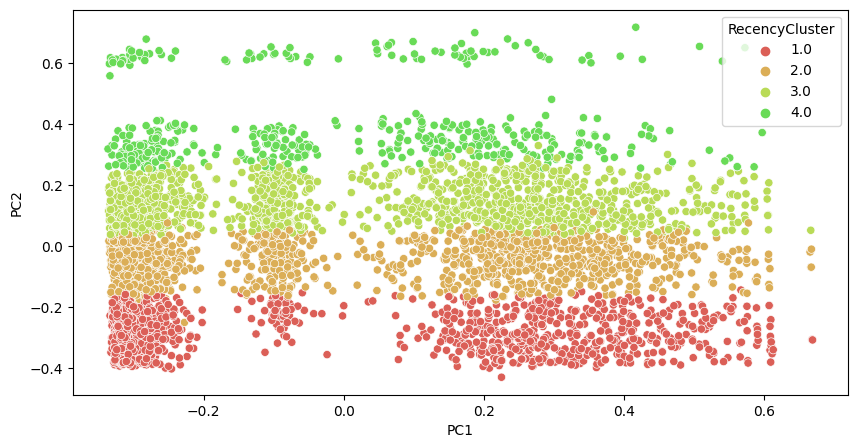

In [27]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='RecencyCluster', n=cluster_no, transform_and_scale_data=True, algorithm='PCA')

#### TSNE

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


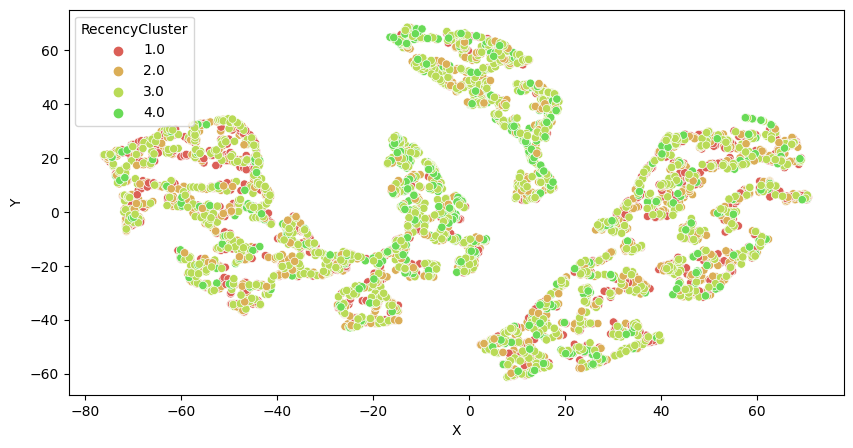

In [28]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='RecencyCluster', n=cluster_no, transform_and_scale_data=True, algorithm='tsne')

#### LDA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


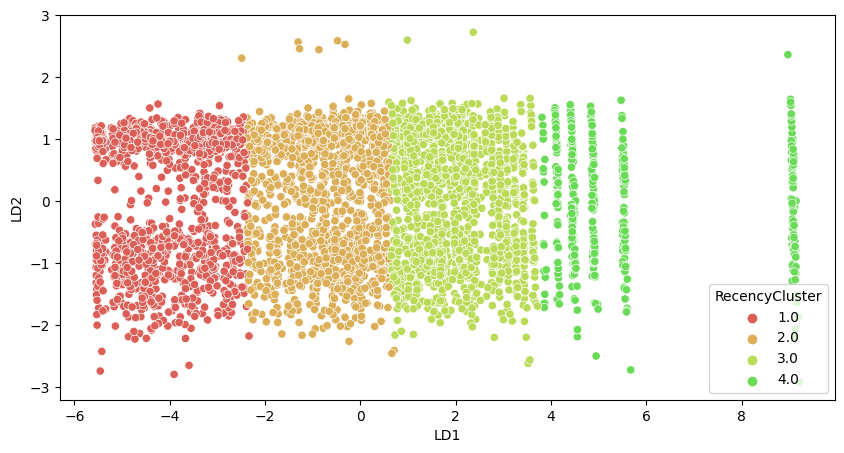

In [29]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='RecencyCluster', n=cluster_no, transform_and_scale_data=True, algorithm='lda')

### Frequency

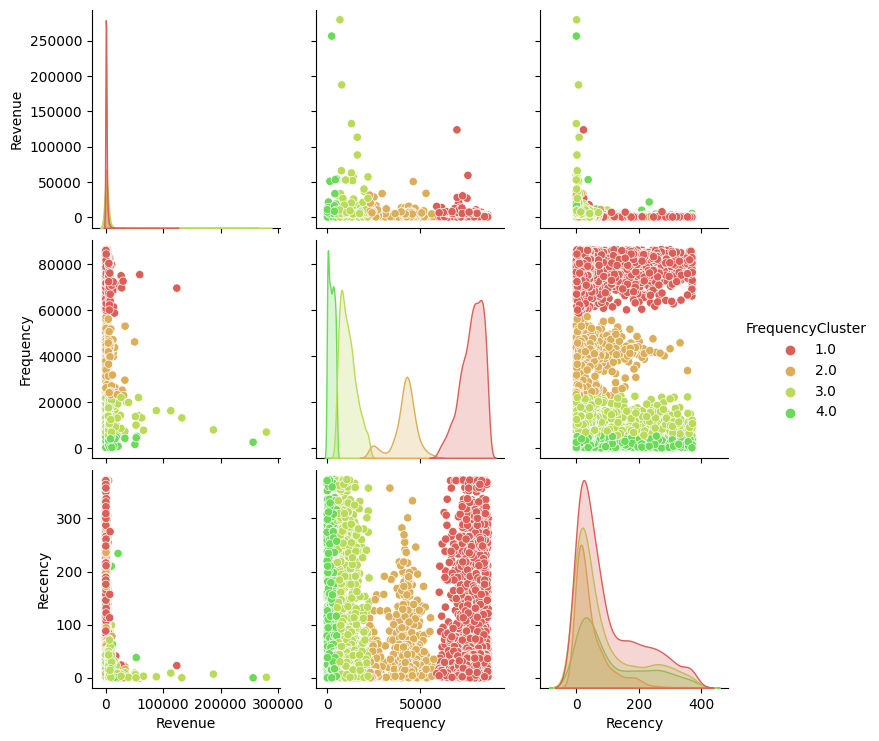

In [30]:
sns.pairplot(rfm[['Revenue', 'Frequency', 'Recency', 'FrequencyCluster']], hue='FrequencyCluster', palette=sns.color_palette("hls",10))

#### PCA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


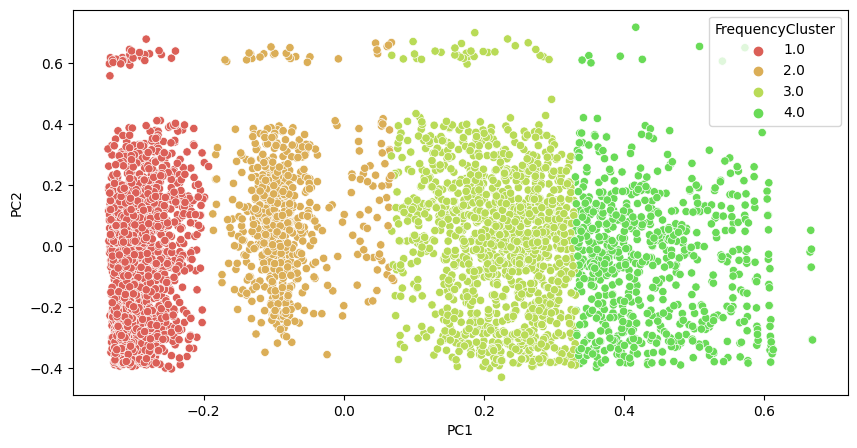

In [31]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='FrequencyCluster', n=cluster_no, transform_and_scale_data=True, algorithm='PCA')

#### TSNE

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


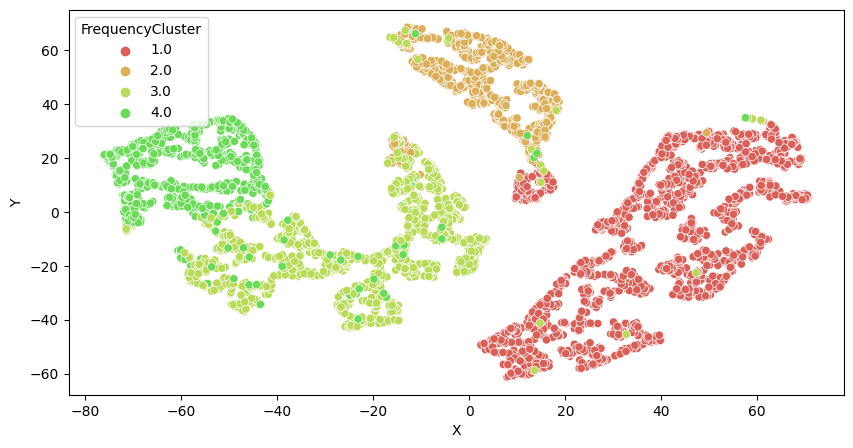

In [32]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='FrequencyCluster', n=cluster_no, transform_and_scale_data=True, algorithm='tsne')

#### LDA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


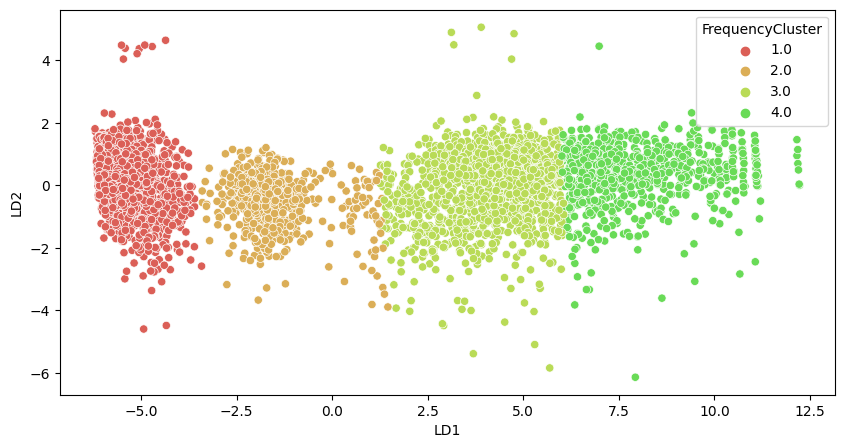

In [33]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='FrequencyCluster', n=cluster_no, transform_and_scale_data=True, algorithm='lda')

### Revenue

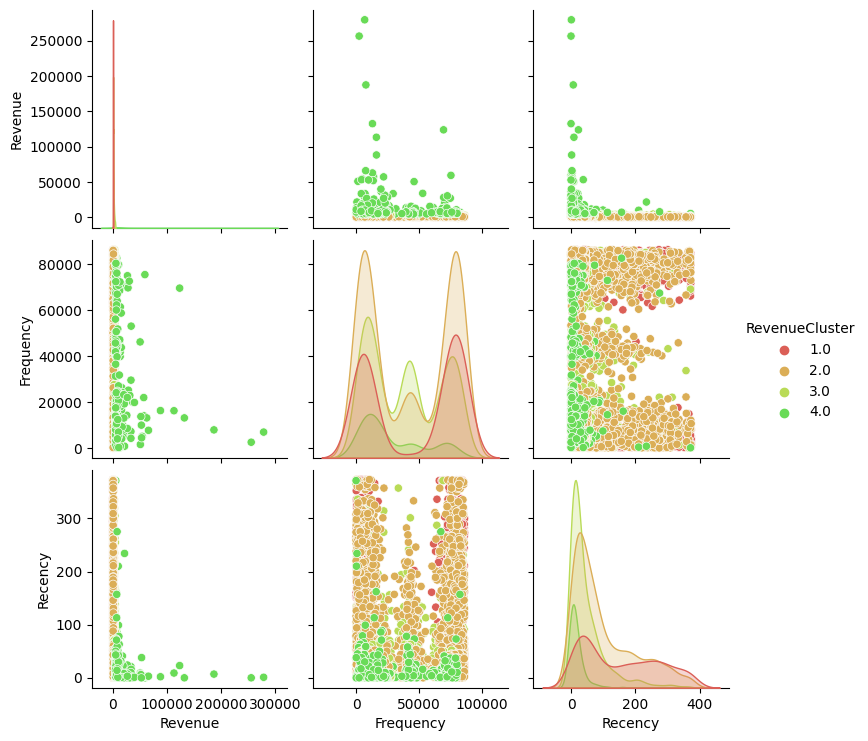

In [34]:
sns.pairplot(rfm[['Revenue', 'Frequency', 'Recency', 'RevenueCluster']], hue='RevenueCluster', palette=sns.color_palette("hls",10))

#### PCA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


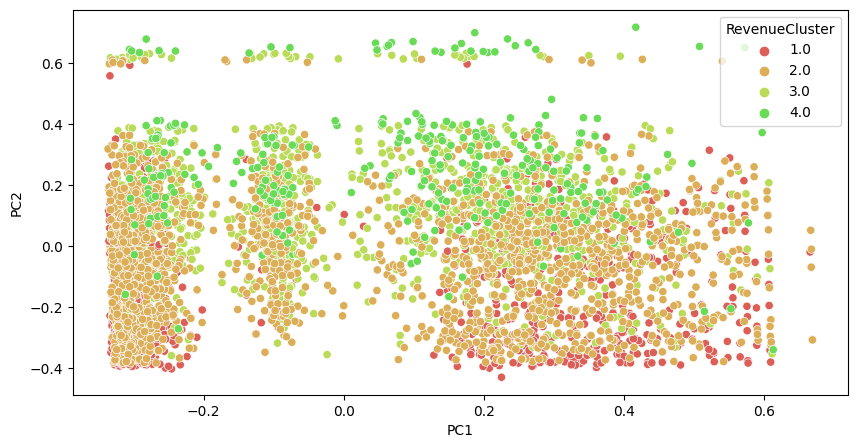

In [35]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='RevenueCluster', n=cluster_no, transform_and_scale_data=True, algorithm='pca')

#### TSNE

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


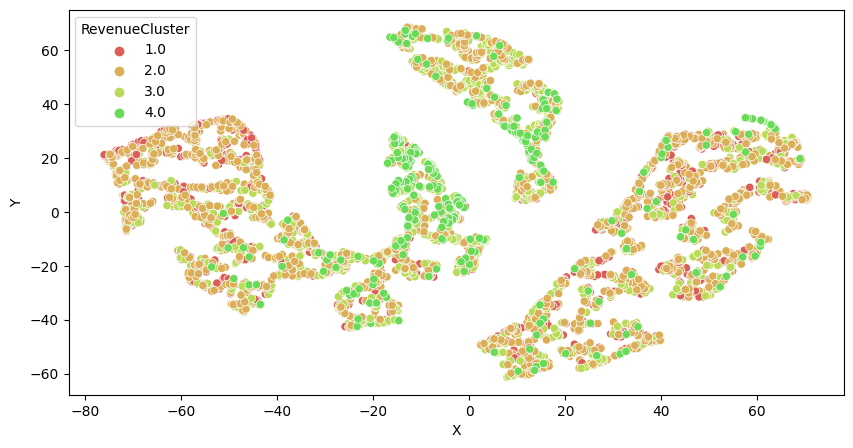

In [36]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='RevenueCluster', n=cluster_no, transform_and_scale_data=True, algorithm='tsne')

#### LDA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


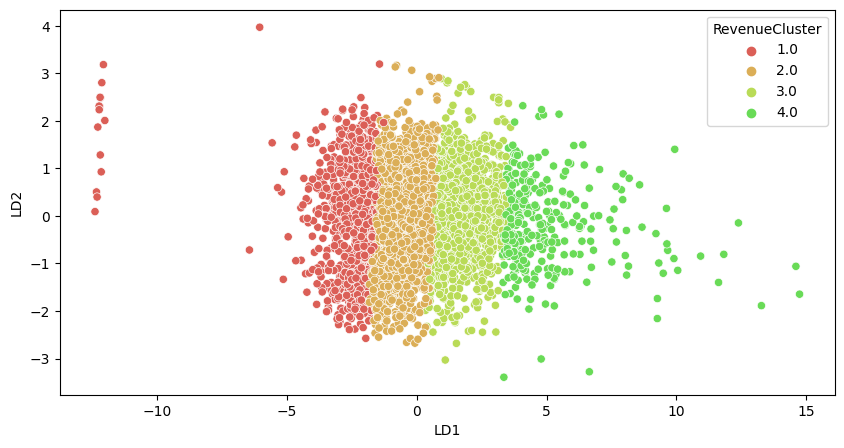

In [37]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='RevenueCluster', n=cluster_no, transform_and_scale_data=True, algorithm='lda')

In [38]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [39]:
rfm.groupby(['FinalCluster'])['Recency'].describe()

count        mean        std   min   25%    50%    75%    max
FinalCluster                                                                
1.0           1181.0  158.088908  93.098452  29.0  74.0  134.0  225.0  372.0
2.0           1196.0   19.528428  14.407286   0.0   8.0   17.0   29.0   63.0
3.0            995.0   19.175879  15.324991   0.0   7.0   17.0   29.0   72.0
4.0            967.0  173.690796  99.224115  32.0  79.0  154.0  260.0  373.0

In [40]:
rfm.groupby(['FinalCluster'])['Frequency'].describe()

count          mean           std      min      25%      50%  \
FinalCluster                                                                  
1.0           1181.0  73417.087214  13384.350088  28440.0  71520.0  77880.0   
2.0           1196.0  63683.979933  17266.879822  26820.0  44430.0  70920.0   
3.0            995.0   9904.130653   6467.896570     60.0   4860.0   9120.0   
4.0            967.0   7092.812823   5427.180783      0.0   2640.0   6360.0   

                  75%      max  
FinalCluster                    
1.0           82320.0  86340.0  
2.0           78720.0  86340.0  
3.0           13980.0  27660.0  
4.0           10680.0  26580.0

In [41]:
rfm.groupby(['FinalCluster'])['Revenue'].describe()

count         mean           std           min      25%  \
FinalCluster                                                             
1.0           1181.0   663.525480    843.027584 -1.165300e+03  203.870   
2.0           1196.0  2098.369699   5029.103133  0.000000e+00  534.815   
3.0            995.0  4327.479056  15969.881102  1.065814e-14  528.170   
4.0            967.0   713.355999   1211.687117 -4.514200e+02  203.300   

                   50%        75%        max  
FinalCluster                                  
1.0            386.530   799.8200   11056.93  
2.0           1092.555  2276.5125  123725.45  
3.0           1389.410  3380.5250  279489.02  
4.0            383.340   748.4600   21535.90

In [42]:
rfm.groupby(['RevenueCluster'])['Revenue'].describe()

count          mean           std      min       25%  \
RevenueCluster                                                          
1.0              975.0    157.600318     65.529742  -141.48   112.430   
2.0             1815.0    569.925539    225.382792  -840.76   374.635   
3.0             1250.0   2134.209137    894.657622 -1165.30  1391.140   
4.0              299.0  14826.401605  28246.816043  4554.87  5572.140   

                    50%         75%        max  
RevenueCluster                                  
1.0              160.19    209.9000     268.05  
2.0              537.48    728.5500    1053.49  
3.0             1880.32   2711.3325    4531.34  
4.0             7066.31  11607.5750  279489.02

In [43]:
rfm.groupby(['FrequencyCluster'])['Frequency'].describe()

count          mean          std      min      25%  \
FrequencyCluster                                                        
1.0               1766.0  77443.522084  5984.954758  58740.0  73515.0   
2.0                663.0  41319.185520  6641.190148  22860.0  39510.0   
3.0               1221.0  11315.380835  4292.519986   5220.0   7800.0   
4.0                689.0   2335.297533  1564.754496      0.0    900.0   

                      50%      75%      max  
FrequencyCluster                             
1.0               78420.0  82320.0  86340.0  
2.0               42390.0  45090.0  57300.0  
3.0               10560.0  13950.0  22830.0  
4.0                2340.0   3690.0   5160.0

In [44]:
rfm.groupby(['RecencyCluster'])['Recency'].describe()

count        mean        std    min     25%    50%    75%  \
RecencyCluster                                                               
1.0             1124.0  242.113879  68.717947  134.0  183.00  238.0  296.0   
2.0             1324.0   72.783988  25.717228   38.0   51.75   67.0   89.0   
3.0             1427.0   19.367204   8.868827    6.0   11.00   18.0   27.0   
4.0              464.0    2.066810   1.482022    0.0    1.00    2.0    3.0   

                  max  
RecencyCluster         
1.0             373.0  
2.0             133.0  
3.0              37.0  
4.0               5.0